In [3]:
from dask.distributed import Client
cluster = Client("tcp://dc-final-reviewpredict-3ff41f773cf84ef5857f52284765f456.main-namespace:8786")
cluster

<Client: 'tcp://192.168.40.68:8786' processes=12 threads=24, memory=177.42 GiB>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import dask
import dask.dataframe as dd

In [5]:
review = pd.read_json("yelp_academic_dataset_review.json", lines=True)
business = pd.read_json("yelp_academic_dataset_business.json", lines=True)

In [6]:
print(review.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


In [7]:
print(business.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


In [8]:
# Restrict to restaurants to centralize dataset
restaurant_mask = business["categories"].str.contains("Restaurants")
restaurant_mask.fillna(value=False, inplace=True)

restaurant = business[restaurant_mask]

merged = review.merge(restaurant, how='inner', on='business_id')

# Take only columns relevant to review prediction
review_subset = merged[["text", "stars_x", "useful", "funny", "cool"]]
review_subset = review_subset.rename({'stars_x': 'stars'}, axis=1)

len(review_subset)

4724471

In [9]:
review_subset.head()

,text,stars,useful,funny,cool
0,"If you decide to eat here, just be aware it is...",3,0,0,0
1,This is the second time we tried turning point...,2,0,0,0
2,The place is cute and the staff was very frien...,4,2,0,1
3,We came on a Saturday morning after waiting a ...,3,0,0,0
4,"Mediocre at best. The decor is very nice, and ...",2,0,0,0


At almost 5 million lines, it'll take way too many resources to train a model on the full dataset. We'll cut it down to a more manageable sample of 20,000.

In [10]:
review_sample = review_subset.sample(n=20000, random_state=1)
review_sample["text"].head()

4101287    Hello, welcome to SUBWAY! \n\nYou'll be hearin...
4112590    Really good ice cream and quick service! We sh...
863802     I used to come here all the time for lunch but...
596751     My wife and I enjoyed a terrific lunch at Rat'...
2715695    My boyfriend and I have been here at least six...
Name: text, dtype: object

In [11]:
review_sample["stars"].value_counts()

5    8693
4    4829
1    2452
3    2290
2    1736
Name: stars, dtype: int64

We'll use stratified K-Fold cross-validation, as 5 star reviews are most common.

In [12]:
from wordcloud import WordCloud

In [13]:
# remove punctuation except whitespace, and make lowercase
review_sample["text_clean"] = review_sample["text"].str.replace("[^\w\s]", "").str.lower()
# remove non-English characters
review_sample["text_clean"] = review_sample["text_clean"].str.replace("[^\x00-\x7F]", "")

# remove stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')
stopwords = list(STOP_WORDS)
review_sample["text_no_stopwords"] = review_sample["text_clean"].apply(lambda x: " ".join([w for w in x.split() if w not in stopwords]))

/tmp/ipykernel_1001/790295939.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  review_sample["text_clean"] = review_sample["text"].str.replace("[^\w\s]", "").str.lower()
/tmp/ipykernel_1001/790295939.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  review_sample["text_clean"] = review_sample["text_clean"].str.replace("[^\x00-\x7F]", "")


In [14]:
review_sample["text_no_stopwords"].head()

4101287    hello welcome subway youll hearing phrase doze...
4112590    good ice cream quick service showed 9pm close ...
863802     come time lunch 20 yrs ago quality food area c...
596751     wife enjoyed terrific lunch rats restaurant qu...
2715695    boyfriend times food service excellent tempted...
Name: text_no_stopwords, dtype: object

In [15]:
from wordcloud import WordCloud

five_star_review = review_sample[review_sample["stars"] == 5]
one_star_review = review_sample[review_sample["stars"] == 1]

five_star = " ".join(i for i in five_star_review["text"])
one_star = " ".join(i for i in one_star_review["text"])

five_star_cloud = WordCloud(stopwords=stopwords, background_color='black').generate(five_star)
one_star_cloud = WordCloud(stopwords=stopwords, background_color='black').generate(one_star)

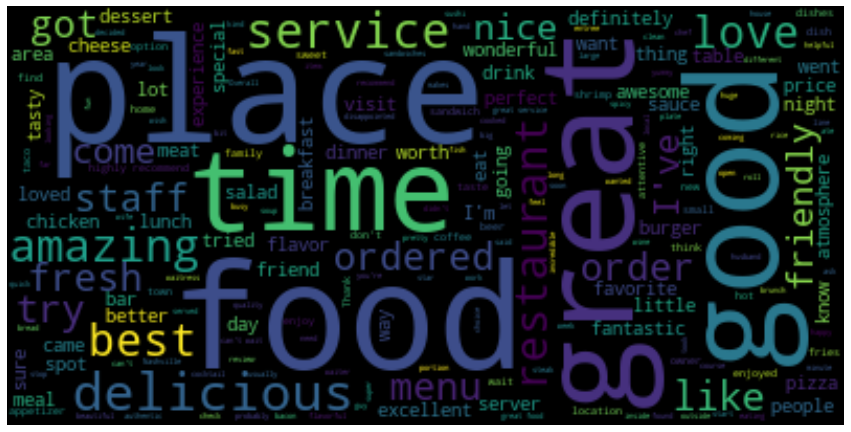

In [18]:
# Five star review word cloud
plt.figure(figsize=(15, 10))
plt.imshow(five_star_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

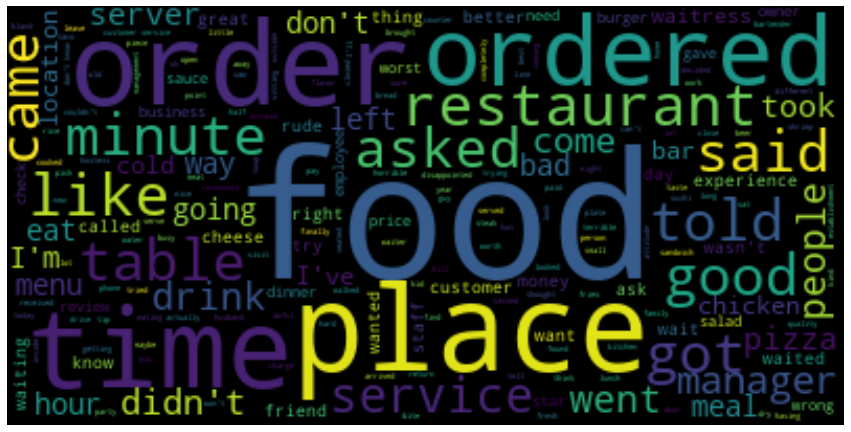

In [19]:
# One star review word cloud
plt.figure(figsize=(15, 10))
plt.imshow(one_star_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Start with bag-of-words using countvectorizer, including punctuation.

In [20]:
corpus = review_sample["text_no_stopwords"]

from sklearn.feature_extraction.text import CountVectorizer
# Todo: Get optimal parameters with gridsearchCV 
bigram_vectorizer = CountVectorizer(token_pattern=r"\b\w+\b",
                                    ngram_range=(1,3), min_df=1)
X = bigram_vectorizer.fit_transform(corpus)
y = review_sample["stars"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# lr with no feature selection
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=1)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score, classification_report, make_scorer
print(classification_report(y_test, y_predict))
print(accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.68      0.73      0.70       640
           2       0.34      0.19      0.25       433
           3       0.47      0.30      0.37       556
           4       0.49      0.44      0.46      1165
           5       0.71      0.86      0.78      2206

    accuracy                           0.62      5000
   macro avg       0.54      0.50      0.51      5000
weighted avg       0.60      0.62      0.60      5000

0.6242


In [22]:
# lr with feature selection
from sklearn.feature_selection import SelectPercentile

selector = SelectPercentile(percentile=10)
selector.fit_transform(X_train, y_train)
feature_select = selector.get_support(indices=True)

feature_select = np.array(feature_select)
X_new = X.tocsr()[:,feature_select]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

print(classification_report(y_test, y_predict))
print(accuracy_score(y_test, y_predict))

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


              precision    recall  f1-score   support

           1       0.64      0.76      0.69       594
           2       0.42      0.10      0.17       447
           3       0.46      0.42      0.44       558
           4       0.53      0.49      0.51      1245
           5       0.71      0.83      0.77      2156

    accuracy                           0.63      5000
   macro avg       0.55      0.52      0.51      5000
weighted avg       0.60      0.63      0.60      5000

0.627


Now we try TF-IDF vectorizer

In [23]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(tfidf, y, random_state=1)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

print(classification_report(y_test, y_predict))
print(accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.70      0.53      0.61       640
           2       0.27      0.01      0.01       433
           3       0.55      0.06      0.10       556
           4       0.43      0.31      0.36      1165
           5       0.58      0.95      0.72      2206

    accuracy                           0.57      5000
   macro avg       0.51      0.37      0.36      5000
weighted avg       0.53      0.57      0.49      5000

0.5684


In [24]:
#TF-IDF with feature extraction
tfidf_selector = SelectPercentile(percentile=10)
selector.fit_transform(X_train, y_train)

feature_select = selector.get_support(indices=True)
feature_select = np.array(feature_select)
X_new = X.tocsr()[:,feature_select]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

print(classification_report(y_test, y_predict))
print(accuracy_score(y_test, y_predict))

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


              precision    recall  f1-score   support

           1       0.66      0.77      0.71       594
           2       0.44      0.10      0.17       447
           3       0.43      0.42      0.43       558
           4       0.54      0.48      0.51      1245
           5       0.71      0.84      0.77      2156

    accuracy                           0.63      5000
   macro avg       0.55      0.52      0.52      5000
weighted avg       0.61      0.63      0.61      5000

0.629


In [25]:
def classification_report_with_accuracy_score(y_true, y_pred):
    
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
#Pipeline incorporating text transformer and logistic regression classifier
text_transformer = Pipeline([
                    ('vectorizer', CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(1,3), min_df=1)),
                    ('tfidf', TfidfTransformer(smooth_idf=False)),
                    ('selector', SelectPercentile(percentile=10))
                ])

pipe = Pipeline([
    ('transform', text_transformer),
    ('clf', LogisticRegression(max_iter=1000, random_state=1))])

X = review_sample['text_no_stopwords']
y = review_sample['stars']

kf = StratifiedKFold()
predicts = cross_val_score(pipe, X, y, cv=kf, 
                           scoring=make_scorer(classification_report_with_accuracy_score), 
                           n_jobs=-1)

print(predicts)

[0.61725 0.6095  0.6045  0.61625 0.6065 ]


In [27]:
# Same as above, but include the reaction columns
reaction_cols = ['useful', 'funny', 'cool']
text_col = "text_no_stopwords"

text_transformer = Pipeline([
                    ('vectorizer', CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(1,3), min_df=1)),
                    ('tfidf', TfidfTransformer(smooth_idf=False)),
                    ('selector', SelectPercentile(percentile=10))
                ])

preprocessor = ColumnTransformer(
    transformers=[('text', text_transformer, text_col)],
    remainder='passthrough'
)

pipe = Pipeline([
    ('transform', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=1))])

X = review_sample[['text_no_stopwords', 'useful', 'funny', 'cool']]
y = review_sample['stars']

kf = StratifiedKFold()
predicts = cross_val_score(pipe, X, y, cv=kf, 
                           scoring=make_scorer(classification_report_with_accuracy_score), 
                           n_jobs=-1)

print(predicts)

[0.61375 0.61375 0.6095  0.6205  0.61   ]
              precision    recall  f1-score   support

           1       0.61      0.72      0.66       490
           2       0.62      0.03      0.05       348
           3       0.47      0.22      0.30       458
           4       0.46      0.51      0.48       966
           5       0.69      0.85      0.76      1738

    accuracy                           0.61      4000
   macro avg       0.57      0.47      0.45      4000
weighted avg       0.60      0.61      0.57      4000

              precision    recall  f1-score   support

           1       0.64      0.79      0.71       490
           2       0.36      0.03      0.06       347
           3       0.43      0.20      0.28       458
           4       0.47      0.51      0.49       966
           5       0.70      0.86      0.77      1739

    accuracy                           0.62      4000
   macro avg       0.52      0.48      0.46      4000
weighted avg       0.58      0.62  

The model performs well with 1 and 5 star reviews but struggles with 2, 3, 4 star reviews. A future goal will be to examine these reviews in greater detail.